In [405]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torchvision as vis

from tqdm import tqdm

In [406]:
style_img = Image.open("style.jpg")
style_img = style_img.resize((500, 500))

style_np = np.array(style_img)

In [407]:
haf_img = Image.open("haf.jpg")
haf_img = haf_img.resize((500, 500))

haf_np = np.array(haf_img)

In [412]:
vgg = vis.models.vgg.vgg11(pretrained=True)

In [413]:
conv1 = nn.Sequential(vgg.features[0], nn.ReLU())
conv1 = conv1.cuda()

In [488]:
haf_tensor = torch.from_numpy(haf_np.transpose(2,0,1)).unsqueeze(0).float()
style_tensor = torch.from_numpy(style_np.transpose(2,0,1)).unsqueeze(0).float()

haf_tensor /= 255
style_tensor /= 255

haf_tensor = haf_tensor.cuda()
style_tensor = style_tensor.cuda()

haf = Variable(haf_tensor, requires_grad=True)

haf_orig = Variable(haf_tensor.clone(), requires_grad=False)

style = Variable(style_tensor)

In [415]:
def imshow(var):
    plt.imshow(var.squeeze(0).permute(1,2,0).data)

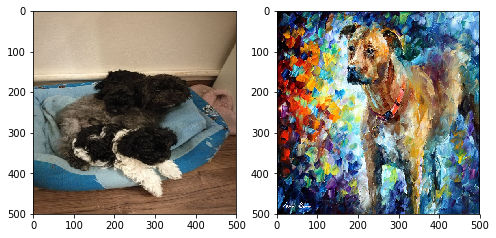

In [416]:
plt.figure(figsize=(8,8))
plt.subplot(121); imshow(haf); plt.subplot(122); imshow(style)

In [417]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [418]:
style_ac = conv1(style)
haf_ac = conv1(haf)

In [419]:
(gram_matrix(style_ac) - gram_matrix(haf_ac)).pow(2).mean()

Variable containing:
1.00000e-08 *
  6.0053
[torch.cuda.FloatTensor of size 1 (GPU 0)]

100%|██████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:17<00:00, 256.45it/s]


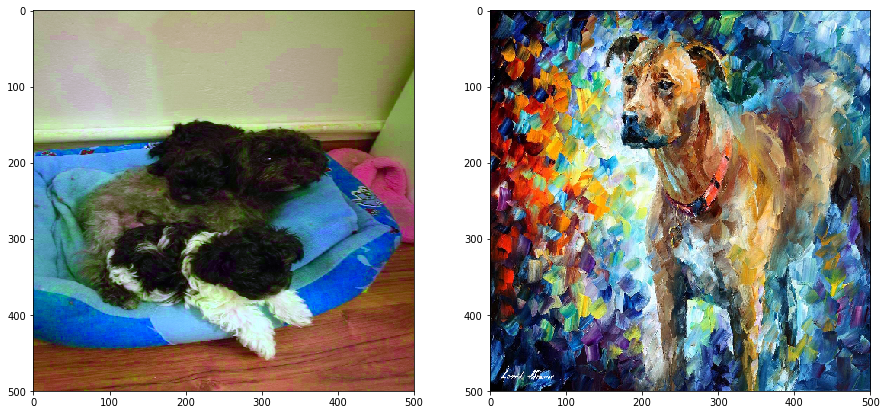

In [490]:
train = optim.Adam([haf], lr=1)
style_losses = []
content_losses = []

def closure():
    train.zero_grad()
    
    style_ac = conv1(style)
    style_gram = gram_matrix(style)
    
    haf_ac = conv1(haf)
    haf_gram = gram_matrix(haf)
    
#     haf_orig_ac = conv1(haf_orig)
    
    style_loss = (haf_gram - style_gram).pow(2).mean()
#     content_loss = 0*(haf_orig_ac - haf_ac).pow(2).mean()
    
    style_losses.append(style_loss.data[0])
#     content_losses.append(content_loss.data[0])
    
    loss = style_loss # + content_loss
    loss.backward()
    return loss

for _ in tqdm(range(20000)):
    
    closure()
    train.step()
    
#     content_loss = (style_ac - haf_ac).pow(2).sum()
#     style_loss = (style_gram - haf_gram).pow(2).mean()
    
#     loss = content_loss + style_loss
#     loss = style_loss
#     train.zero_grad()
#     loss.backward()
#     loss.backward()
#     loss.backward(retain_graph=True)

#     haf.data.sub_(haf.grad.data)
#     haf.grad.data.zero_()
#     haf.data.clamp_(0, 1)
#     haf.mean()

plt.figure(figsize=(15,10))
plt.subplot(121); imshow(haf.clamp(0, 1)); plt.subplot(122); imshow(style)

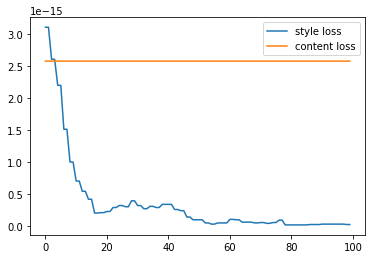

In [474]:
plt.plot(style_losses, label="style loss")
plt.plot(np.array(content_losses), label="content loss")
plt.legend()

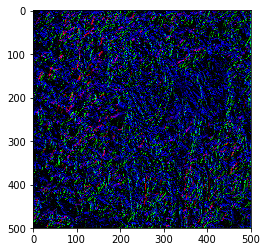

In [361]:
imshow(conv1(style)[:,:3,:,:])

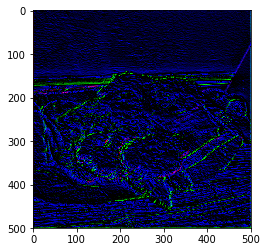

In [360]:
imshow(conv1(haf)[:,:3,:,:])

In [309]:
for param in conv1.parameters(): param.requires_grad = False

In [97]:
[param.requires_grad for param in conv1.parameters()]

[True, True]

In [118]:
x = Variable(torch.from_numpy(np.random.randn(10, 10).transpose(0, 1)), requires_grad=True)

In [119]:
y = x.unsqueeze(0).sum()

In [120]:
y.backward()

In [121]:
x.grad

Variable containing:
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
    1     1     1     1     1     1     1     1     1     1
[torch.DoubleTensor of size 10x10]

In [141]:
x = Variable(haf_tensor, requires_grad=True)

In [165]:
loss = (conv1(x) - conv1(style)).pow(2).mean()
loss.backward()
x.grad

Variable containing:
( 0 , 0 ,.,.) = 
   0.0333  -2.0969  -2.0973  ...   -2.0975  -2.0972   2.4908
   0.2028  -6.9051  -6.9056  ...   -6.9059  -6.9055  -2.5104
   0.2024  -6.9057  -6.9063  ...   -6.9064  -6.9059  -2.5106
            ...               ⋱              ...            
   0.2021  -6.9060  -6.9064  ...   -6.9063  -6.9058  -2.5106
   0.2025  -6.9054  -6.9057  ...   -6.9059  -6.9055  -2.5104
   0.9933  -4.8507  -4.8509  ...   -4.8510  -4.8506  -1.0428

( 0 , 1 ,.,.) = 
   3.5245   5.4245   5.4240  ...    5.4237   5.4241   8.5023
  -1.1917  -5.6917  -5.6924  ...   -5.6929  -5.6924  -0.5391
  -1.1922  -5.6924  -5.6933  ...   -5.6934  -5.6929  -0.5394
            ...               ⋱              ...            
  -1.1926  -5.6931  -5.6935  ...   -5.6934  -5.6929  -0.5395
  -1.1922  -5.6925  -5.6928  ...   -5.6930  -5.6925  -0.5393
  -4.0199 -10.2053 -10.2056  ...  -10.2056 -10.2053  -3.5424

( 0 , 2 ,.,.) = 
   8.2694  12.2797  12.2796  ...   12.2794  12.2795  12.6491
  10.7281  